# Data cleaning and EDA
Mains TODO:

Dealing with outlayers and empty values. 

Prepare the time series adecuate for training (2 summers for max pressure forecasting (region of interest because it is when free cooling is mainly not available) and 1 year at least for electrical consumption). 

Then we will try to forecast the next 24 hours (latest 48 data points). 

We will obtain RMSE and SMAPE (Pending BIC and AIC) for 12 hours forecast (24 data points), 24 hours (48 data points) and 7 days (168 latest data points)

5 Exogenous average Temperature time series (In, Out, Ambient, Evaporator, Ambient-Setpoint) in Bars

1 Exogenous cluster nodes total average Electric Consumption variable in W (will be converted to Kw)

1 Exogenous n working compressors time Series

2 Main Time Series - max Pressure in Bars and Chiller total average Power consumption in kW

All of them have a 30 min sliding window granularity

In [7]:
# imports and useful variables
import sys
import os
import numpy as np
import pandas as pd
import dask as dd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.options.display.float_format = "{:.2f}".format
sns.set_style("whitegrid")
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

# Useful directory variables
src_path = os.getcwd()
root_path = os.path.dirname(src_path)
data_path = root_path + "/datasets"
visualization_path = root_path + "/data_visualization"
print(os.listdir(data_path + "/03_primary"))
print(os.listdir(data_path + "/04_feature"))
# First lets convert to KW
consumption_cluster = pd.read_parquet(
    data_path + "/03_primary/" + "consumption_total_average_30_min_W"
)
consumption_cluster.total_average_power_consumption_W = (
    consumption_cluster.total_average_power_consumption_W / 1000
)
consumption_cluster = consumption_cluster.rename(
    columns={"total_average_power_consumption_W": "total_average_power_consumption_kW"}
)

consumption_chillers = pd.read_parquet(
    data_path + "/03_primary/" + "chiller_1and2_consumption_total_average_30_min_kW"
)
max_pressure = pd.read_parquet(data_path + "/04_feature/" + "max_pressure_Bars")
n_compressors = pd.read_parquet(data_path + "/04_feature/" + "n_working_compressors")
temperature = pd.read_parquet(
    data_path + "/04_feature/" + "average_temperature_Degrees"
)
for i in [
    consumption_cluster,
    consumption_chillers,
    max_pressure,
    n_compressors,
    temperature,
]:
    # Spark steps regarding the time window (works with posix time) can lead to duplicate entries, lets ensure each dataframe does not contain duplicated rows
    i.drop_duplicates(inplace=True)
    i.time = pd.to_datetime(i.time)
    i["year"] = i.time.dt.year
    i["month"] = i.time.dt.month
    i["week"] = i.time.dt.week
# Preparing final dataframes with the deesired window time frames
consumption_train = consumption_cluster[["time"]].copy()
consumption_train = consumption_train[
    consumption_train.time >= pd.to_datetime("2020-01-01 00:00:00")
]
consumption_train = consumption_train[
    consumption_train.time < pd.to_datetime("2021-06-01 00:00:00")
]
pressure_train = consumption_cluster[["time"]].copy()
pressure_train = pressure_train[
    pressure_train.time >= pd.to_datetime("2019-06-21 00:00:00")
]
pressure_train = pressure_train[
    pressure_train.time < pd.to_datetime("2020-09-23 00:00:00")
]
pressure_train = pressure_train[
    (pressure_train.time < pd.to_datetime("2019-09-23 00:00:00"))
    | (pressure_train.time >= pd.to_datetime("2020-06-21 00:00:00"))
]
consumption_cluster.set_index("time", inplace=True, drop=False)


['active_chiller', 'consumption_total_average_30_min_W', 'chiller_1and2_consumption_total_average_30_min_kW', 'chiller_1and2_compressor_1and2_pressure_max_30min_P', 'chiller_1and2_temperatureAll_average_30min_P']
['max_pressure_Bars', 'n_working_compressors', 'average_temperature_Degrees']


# Consumption cluster cleaning and study

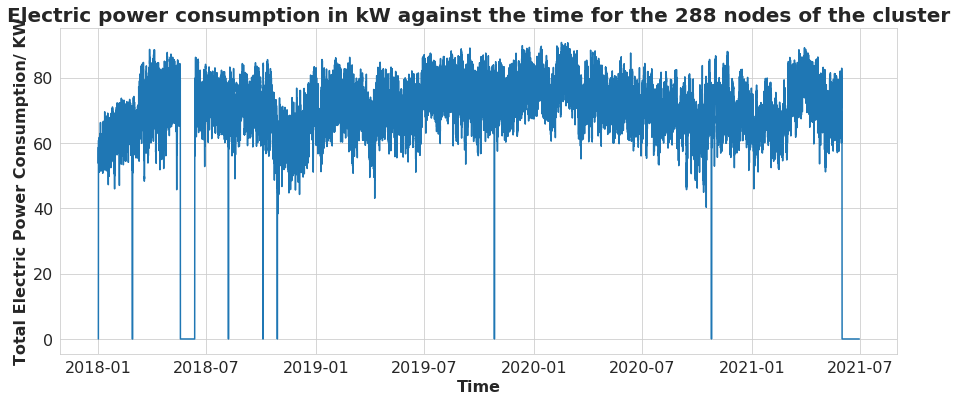

In [2]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    consumption_cluster["time"],
    consumption_cluster["total_average_power_consumption_kW"],
)

ax.set_title(
    "Electric power consumption in kW against the time for the 288 nodes of the cluster",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Total Electric Power Consumption/ KW", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
# plt.savefig(visualization_path+"/c6601_daily_last2years_ts.svg", format="svg",dpi =600)
plt.show()
plt.close()


As discussed, and because of both seeting Nan to 0 in Pyspark plus ffill from the Grafana Dashboard and Hive Data Lake owners. However, as discussed with Javier, it should not be 0 consumption, only when restarting the cluster, which is not sigfnificative. Lets substitute by interpolation on those few outlayers.

In [8]:
consumption_cluster.total_average_power_consumption_kW[
    consumption_cluster.total_average_power_consumption_kW < 42
] = np.nan
consumption_cluster.total_average_power_consumption_kW = (
    consumption_cluster.total_average_power_consumption_kW.interpolate(method="time")
)
# consumption_cluster.total_average_power_consumption_kW = (
#     consumption_cluster.total_average_power_consumption_kW.interpolate()
# )
consumption_cluster.total_average_power_consumption_kW.fillna(
    consumption_cluster.total_average_power_consumption_kW.mean(), inplace=True
)  # Just for the first value
consumption_cluster = consumption_cluster.copy()


/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


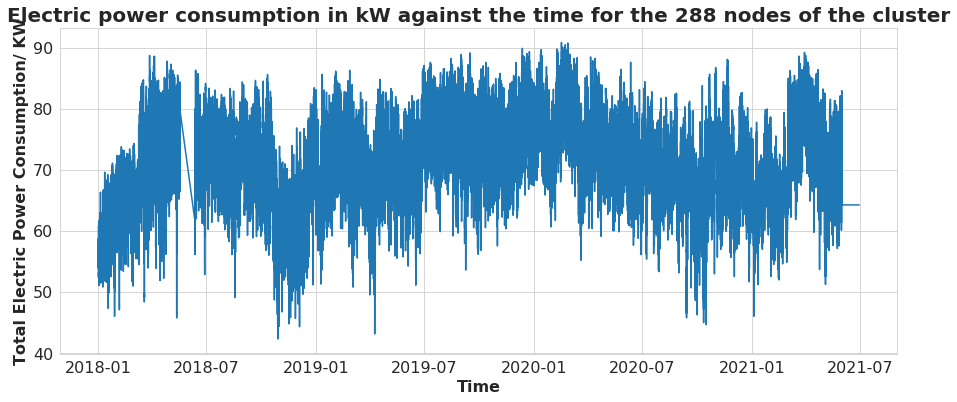

In [3]:
# Nuevamente, aunque preferiremos evitar las regiones donde se han interpolado muchos puntos (2018 principalmente)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    consumption_cluster["time"],
    consumption_cluster["total_average_power_consumption_kW"],
)

ax.set_title(
    "Electric power consumption in kW against the time for the 288 nodes of the cluster",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Total Electric Power Consumption/ KW", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
# plt.savefig(visualization_path+"/c6601_daily_last2years_ts.svg", format="svg",dpi =600)
plt.show()
plt.close()


In [9]:
#Tomamos un año entero para trabajar con el consumo y dos veranos para la presion
consumption_cluster.reset_index(drop = True, inplace=True)
consumption_train = pd.merge(consumption_train, consumption_cluster, on = "time")
pressure_train = pd.merge(pressure_train, consumption_cluster, on = "time")

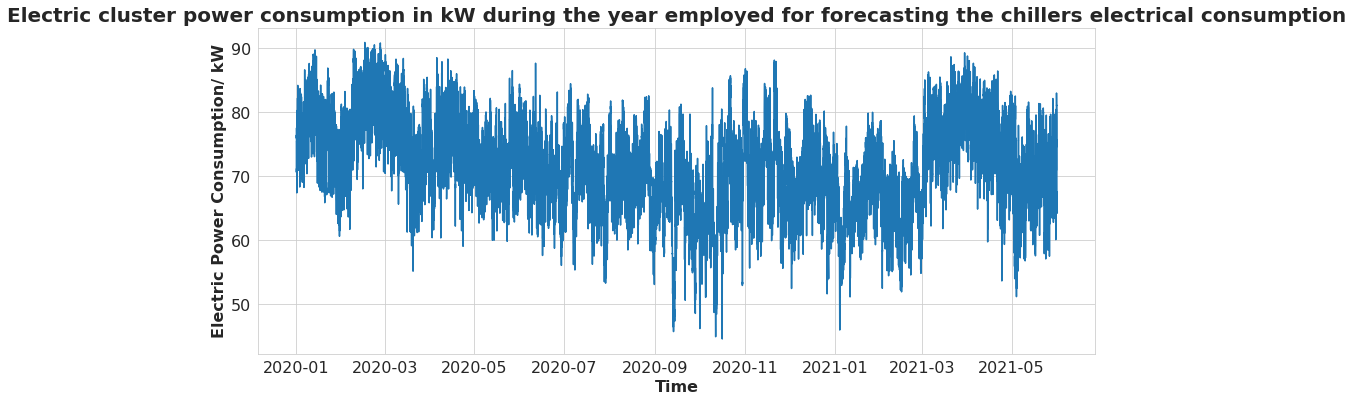

In [6]:
# Nuevamente, aunque preferiremos evitar las regiones donde se han interpolado muchos puntos (2018 principalmente)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    consumption_train["time"], consumption_train["total_average_power_consumption_kW"], #consumption_train["total_average_power_consumption_kW_movingAverage"]
)

ax.set_title(
    "Electric cluster power consumption in kW during the year employed for forecasting the chillers electrical consumption",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Electric Power Consumption/ kW", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
plt.savefig(visualization_path+"/cluster_consumption_train.svg", format="svg",dpi =600)
plt.show()
plt.close()


Maybe too granular to visualize, lets visualize the region to predict:

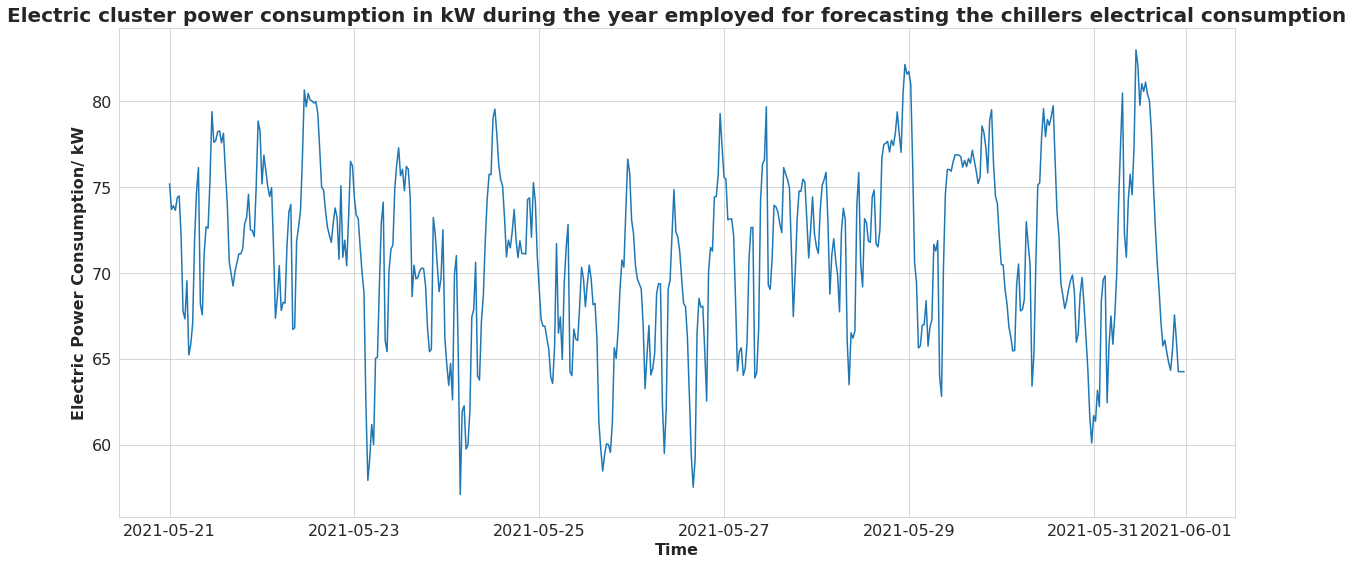

In [7]:
# Nuevamente, aunque preferiremos evitar las regiones donde se han interpolado muchos puntos (2018 principalmente)
consumption_train_Validation = consumption_train[consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")].copy()
fig, ax = plt.subplots(figsize=(20, 9))
sns.lineplot(
    consumption_train_Validation["time"], consumption_train_Validation["total_average_power_consumption_kW"], #consumption_train["total_average_power_consumption_kW_movingAverage"]
)

ax.set_title(
    "Electric cluster power consumption in kW during the year employed for forecasting the chillers electrical consumption",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Electric Power Consumption/ kW", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
plt.savefig(visualization_path+"/cluster_consumption_ValidationMonth.svg", format="svg",dpi =600)
plt.show()
plt.close()


Text(0, 0.5, 'Cluster Power Consumption/ kW')

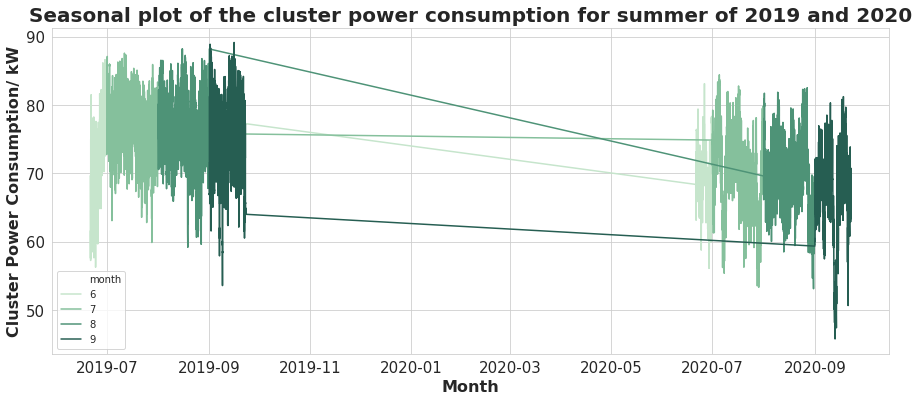

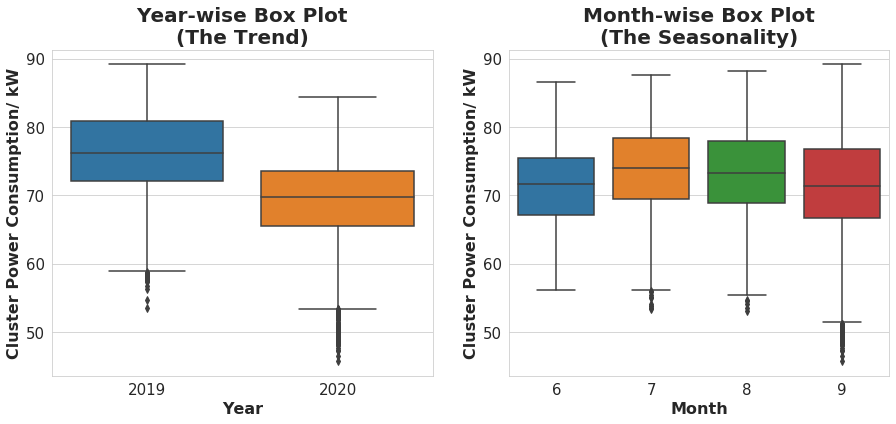

In [21]:
variable = 'total_average_power_consumption_kW'
fig, ax = plt.subplots(figsize=(15, 6))

palette = sns.color_palette("ch:2.5,-.2,dark=.3", 4)
sns.lineplot(pressure_train['time'], pressure_train[variable], hue=pressure_train['month'], palette=palette)
ax.set_title('Seasonal plot of the cluster power consumption for summer of 2019 and 2020', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Cluster Power Consumption/ kW', fontsize = 16, fontdict=dict(weight='bold'))


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(pressure_train['year'], pressure_train[variable], ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Cluster Power Consumption/ kW', fontsize = 16, fontdict=dict(weight='bold'))

sns.boxplot(pressure_train['month'], pressure_train[variable], ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Cluster Power Consumption/ kW', fontsize = 16, fontdict=dict(weight='bold'))

# Pressure plots

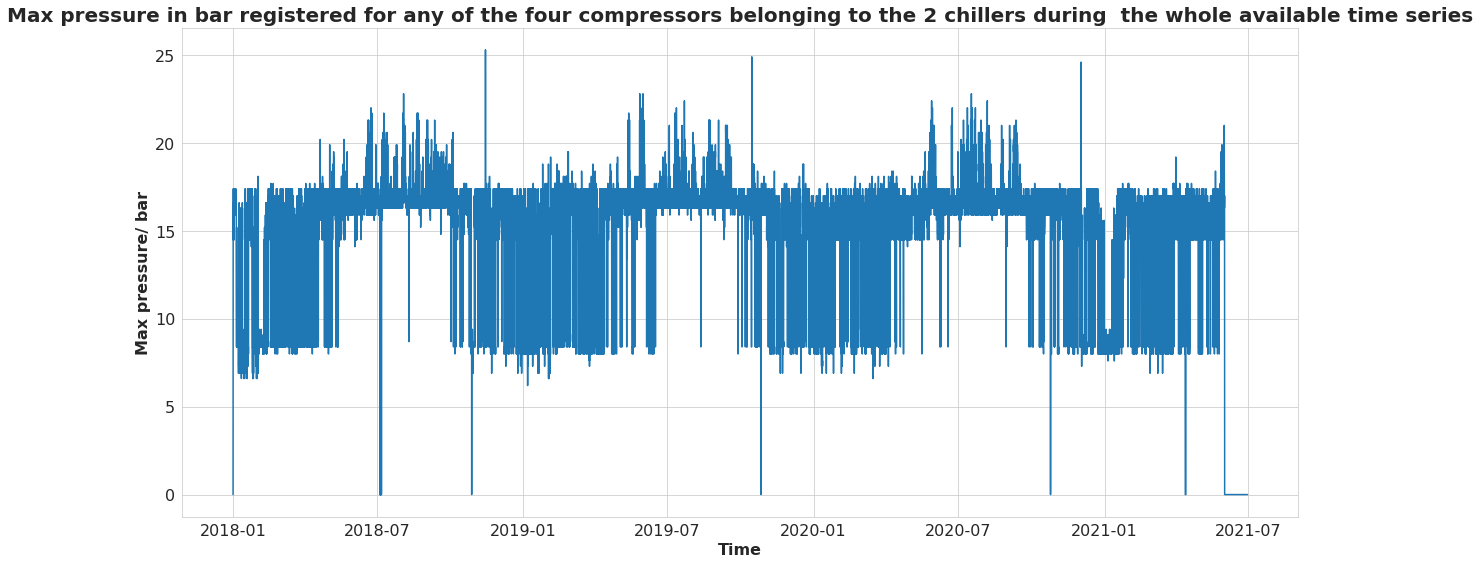

In [12]:
# Nuevamente, aunque preferiremos evitar las regiones donde se han interpolado muchos puntos (2018 principalmente)
#consumption_train_Validation = consumption_train[consumption_train.time >= pd.to_datetime("2021-05-21 00:00:00")].copy()
fig, ax = plt.subplots(figsize=(20, 9))
sns.lineplot(
    max_pressure["time"], max_pressure["max_pressure_Bars"], #consumption_train["total_average_power_consumption_kW_movingAverage"]
)

ax.set_title(
    "Max pressure in bar registered for any of the four compressors belonging to the 2 chillers during  the whole available time series",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Max pressure/ bar", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
# plt.savefig(visualization_path+"/cluster_consumption_ValidationMonth.svg", format="svg",dpi =600)
plt.show()
plt.close()


In [10]:
max_pressure.set_index("time", inplace=True, drop=False)
max_pressure.max_pressure_Bars[
    (max_pressure.max_pressure_Bars <5) & (max_pressure.max_pressure_Bars>24)
] = np.nan
# max_pressure.max_pressure_Bars = (
#     max_pressure.max_pressure_Bars.interpolate(method="time")
# )
max_pressure.max_pressure_Bars.fillna(
    max_pressure.max_pressure_Bars.mean(), inplace=True
)  # Just for the first value
max_pressure.max_pressure_Bars = max_pressure.max_pressure_Bars.copy()
max_pressure.reset_index(drop = True, inplace=True)

#Tomamos un año entero para trabajar con el consumo y dos veranos para la presion
consumption_cluster.reset_index(drop = True, inplace=True)
consumption_train = pd.merge(consumption_train, max_pressure[["time", "max_pressure_Bars"]], on = "time")
pressure_train = pd.merge(pressure_train, max_pressure[["time", "max_pressure_Bars"]], on = "time")

/opt/cesga/anaconda/Anaconda3-2020.02-ml/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


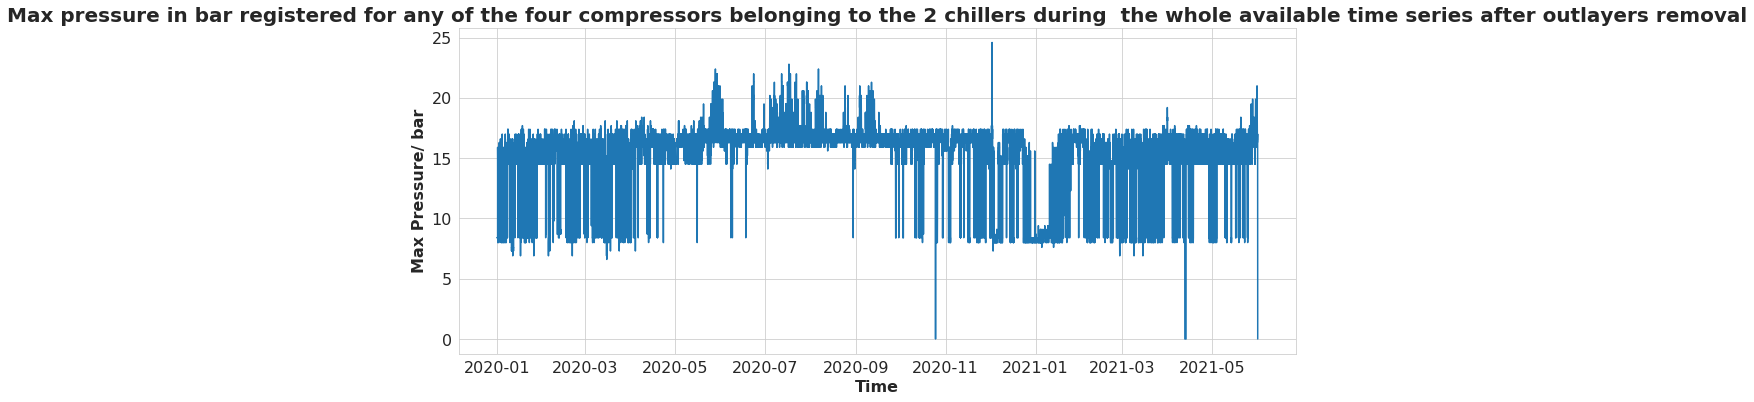

In [11]:
# Nuevamente, aunque preferiremos evitar las regiones donde se han interpolado muchos puntos (2018 principalmente)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    consumption_train["time"], consumption_train["max_pressure_Bars"], #consumption_train["total_average_power_consumption_kW_movingAverage"]
)

ax.set_title(
    "Max pressure in bar registered for any of the four compressors belonging to the 2 chillers during  the whole available time series after outlayers removal",
    fontsize=20,
    loc="center",
    fontdict=dict(weight="bold"),
)
ax.set_xlabel("Time", fontsize=16, fontdict=dict(weight="bold"))
ax.set_ylabel(
    "Max Pressure/ bar", fontsize=16, fontdict=dict(weight="bold")
)
plt.tick_params(axis="y", which="major", labelsize=16)
plt.tick_params(axis="x", which="major", labelsize=16)
plt.savefig(visualization_path+"/ma_pressure_train.svg", format="svg",dpi =600)
plt.show()
plt.close()
